In [1]:
import DPrivacy as dp
from ChoiceMaker import DTChoice
from sklearn import model_selection, feature_selection
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
%matplotlib inline
import pickle
import collections

In [2]:
class DB:
    def __init__(self, X, y, X_test, y_test, epsilon=1, depth=0, max_depth=0):
        self.epsilon = epsilon
        self.ncol = X.shape[1]
        self.X = X
        self.y = y
        self.X_test = X_test
        self.y_test = y_test
        self.depth = depth
        self.max_depth = max_depth
        #branching_factor?
        
class DBMetas:
    def __init__(self):
        self.sensitivities = collections.OrderedDict((
        ('nrow', 1), ('ncol', 0), ('eps', 0), ('depth', 0), ('C', 0), ('bf', 0), ('t', 0)
                                                    ))
    
    def __call__(self, dataset):
        att_sizes = np.array([len(dataset.X[c].cat.categories) for c in dataset.X])
        return collections.OrderedDict((
                ('nrow', dataset.X.shape[0]), 
                ('ncol', dataset.X.shape[1]),
                ('eps', dataset.epsilon),
                ('depth', dataset.depth),
                ('C', len(dataset.y.cat.categories)),
                ('bf', att_sizes.mean()),
                ('t', att_sizes.max()) ))
def entropy(y):
    arr = pd.value_counts(y)
    arr = arr[arr > 0]
    arr = arr/arr.sum()
    return (-np.log2(arr) * arr).sum()

In [3]:
#alg_list
class TreePart:
    def __init__(self, splits=5):
        self.splits=splits
        self.kf = model_selection.KFold(splits)
        self.lo = model_selection.LeaveOneOut()
    def get_expected_correct(self, y, epsilon):
        if len(y) == 0:
            return 0
        tot_correct = 0
        if len(y) < self.splits:
            gen = self.lo.split(y)
        else:
            gen = self.kf.split(y)
        for train_idx, test_idx in gen:
            hist = pd.value_counts(y.iloc[train_idx])
            noisy_hist = dp.hist_noiser(hist, epsilon)
            pred = noisy_hist.idxmax()
            tot_correct += (y.iloc[test_idx] == pred).sum()
        return tot_correct / len(y)
    
class Leaf(TreePart):
    def error(self, db):
        if len(db.y) == 0:
            return 0
        return 1.0-self.get_expected_correct(db.y, db.epsilon)
    def run(self, db):
        frequencies = pd.value_counts(db.y)
        noisy_freqs = dp.hist_noiser(frequencies, db.epsilon)
        return np.repeat(noisy_freqs.idxmax(), db.y_test.size)
    
#This error is a little optimistic because it doesn't account for the exponential mechanism at low epsilon.
class Split(TreePart):
    def error(self, db):
        if len(db.y) == 0:
            return 0
        corrects = []
        probs = []
        for col in db.X.columns:
            x = db.X[col]
            cats = x.cat.categories
            correct = 0
            tot_ent = 0
            for cat in cats:
                leaf_correct = self.get_expected_correct(db.y[x == cat], db.epsilon)
                correct += leaf_correct * (x == cat).sum()
                ent = entropy(db.y[x == cat])
                tot_ent += ent*(x==cat).sum()
            correct /= len(db.y)
            corrects.append(correct)
            probs.append(tot_ent)
        C = np.array(corrects)
        probs = np.array(probs)
        probs -= probs.min()
        D = np.exp(-probs*db.epsilon/13)
        probs = D/D.sum()
        return 1-probs.dot(C)
    def run(self, db):
        return None
tree_algs = {'leaf': Leaf(), 'split': Split()}

In [4]:
split = Split()
leaf = Leaf()
tree_algs = {'leaf': Leaf(), 'split': Split()}

In [5]:
class PDTree:
    def __init__(self):
        pass
    
    def entropy(self, y):
        arr = pd.value_counts(y)
        arr = arr[arr > 0]
        arr = arr/arr.sum()
        return (-np.log2(arr) * arr).sum()
    
    def decision_helper(self, db, cm):
        action = cm.choose(db)
        if db.depth == db.max_depth:
            action = leaf.run(db)
        if action is not None:
            return action
        utils = []
        for col in db.X.columns:
            x = db.X[col]
            cats = x.cat.categories
            cur_ent = 0
            for cat in cats:
                ent = self.entropy(db.y[x == cat])
                cur_ent += ent * (x == cat).sum()
            #cur_ent /= len(db.y)
            utils.append(-cur_ent)
        best_idx = dp.exp_mech(utils, db.epsilon, 13) #Change sensitivity
        col_name = db.X.columns[best_idx]
        new_cols = db.X.columns[db.X.columns != col_name]
        splitX = db.X[col_name]
        splitX_test = db.X_test[col_name]
        preds = np.repeat(db.y.cat.categories[0], len(db.y_test))
        for att in splitX_test.unique():
            train_split = db.X.loc[splitX == att, new_cols]
            y_split = db.y[splitX == att]
            test_split_loc = db.X_test[col_name] == att 
            test_split = db.X_test.loc[test_split_loc, new_cols]
            test_split_y = db.y_test.loc[test_split_loc]
            if(test_split_y.size > 0):
                db_new = DB(train_split, y_split, test_split, test_split_y, db.epsilon, db.depth+1, db.max_depth)
                preds[test_split_loc] = self.decision_helper(db_new, cm)
        return preds
    
    def fit_and_predict(self, data, cm):
        budget = data.epsilon / data.X.shape[1]
        data.epsilon = budget
        return self.decision_helper(data, cm)

In [150]:
class CoefCM:
    def __init__(self, tree_algs, coefs, const):
        self.m = DBMetas()
        self.tree_algs = tree_algs
        self.coefs = np.array(coefs)
        self.const = const
    def choose(self, data, ratio=0.3):
        budget = data.epsilon*ratio
        metas = self.m(data)
        metas['nrow'] += dp.laplacian(budget, sensitivity=1)[0]
        data.epsilon -= budget
        metas = np.array(list(metas.values()))
        metas = np.log(np.maximum(metas, 1))
        if metas.dot(self.coefs) <= self.const:
            return self.tree_algs['leaf'].run(data)
        else:
            return self.tree_algs['split'].run(data)
fried_cm = CoefCM(tree_algs, [1, 0, 1, 0, -1, 0, -1], np.log(1.414))

In [127]:
metas = test_cm1.m(data_train[0][0])

In [128]:
metas = np.array(list(metas.values()))

In [129]:
np.log(np.maximum(metas, 1))

array([ 8.25244609,  2.07944154,  0.        ,  0.        ,  1.60943791,
        1.21639532,  1.60943791])

### DATASETS

In [6]:
nurs = pd.read_csv('../datasets/nursery.data', header=None)
nurs = nurs.apply(lambda x: x.astype('category'))

In [7]:
skin = pd.read_csv('data/Skin.csv', sep='\t', header=None)
skin = skin.apply(lambda x: x.astype('category'))

In [8]:
default = pd.read_csv('data/default.csv', header=1)
default = default.drop('ID', axis=1)

In [9]:
def discretize(col, n_quantiles):
    L = np.linspace(0, 1, n_quantiles, endpoint=False) + 1.0/n_quantiles
    L = col.quantile(L)
    return L.searchsorted(col)

In [10]:
cols = [c for c in default.columns if 'AMT' in c]
default[cols] = default[cols].apply(lambda x: discretize(x, 5))
#Columns remaining: AGE, LIMIT_BAL, PAY_n,
default.LIMIT_BAL = discretize(default.LIMIT_BAL, 10)
default.AGE = discretize(default.AGE, 6)
default = default.apply(lambda x: x.astype('category'))

In [11]:
loan = pd.read_csv('../datasets/student-loan.csv')
loan = loan.apply(lambda x: x.astype('category'))

In [12]:
adult = pd.read_csv('data/adult.data', header=None)
adult = adult.rename(columns = {0: 'age', 1: 'workclass', 2: 'fnlwgt', 3: 'education', 
                                4: 'education_num', 5: 'marital_status', 6: 'occupation',
                                7: 'relationship', 8: 'race', 9: 'sex', 10: 'capital_gain',
                                11: 'capital_loss', 12: 'hours_per_week', 13: 'native_country', 14: 'TARGET'})

In [13]:
adult.age = discretize(adult.age, 7)
adult.fnlwgt = discretize(adult.fnlwgt, 10)
adult.capital_gain = discretize(adult.capital_gain, 6)
adult.capital_loss = discretize(adult.capital_loss, 6)
adult.hours_per_week = discretize(adult.hours_per_week, 6)

In [14]:
def world_region(elem):
    elem = elem.strip()
    if elem in ['Cuba', 'Jamaica', 'Mexico', 'South', 'Puerto-Rico', 'Honduras', 'Columbia', 'Ecuador', 'Haiti',\
                'Dominican-Republic', 'El-Salvador', 'Guatemala', 'Peru', 'Trinadad&Tobago', 'Nicaragua']:
        return 1
    if elem in ['Philippines', 'Cambodia', 'Thailand', 'Laos', 'Taiwan', 'China', 'Japan',\
                'Outlying-US(Guam-USVI-etc)', 'Hong', 'Vietnam', 'India', 'Iran']:
        return 2
    if elem in ['England', 'Canada', 'France', 'Germany', 'Italy', 'Poland', 'Portugal',\
                'Yugoslavia', 'Scotland', 'Greece', 'Ireland', 'Hungary', 'Holand-Netherlands']:
        return 3
    if elem == 'United-States':
        return 4
    if elem == '?':
        return 5
    assert False
adult.native_country = adult.native_country.apply(world_region)

In [15]:
adult = adult.apply(lambda x: x.astype('category'))

In [16]:
lending = pd.read_csv('data/fam_credit_ss.csv')

In [17]:
lending.income = discretize(lending.income, 8)
lending.age = discretize(lending.age, 5)
lending.work_hours = discretize(lending.work_hours, 5)
lending.employment = discretize(lending.employment, 6)
lending.auto_insurance = discretize(lending.auto_insurance, 10)

In [18]:
lending = lending.apply(lambda x: x.astype('category'))

In [19]:
leaf = Leaf()
split = Split()

In [20]:
class null_cm:
    def __init__(self):
        pass
    def choose(self, db):
        if db.depth < db.max_depth:
            return split.run(db)
        else:
            return leaf.run(db)

### Experiments

In [21]:
def get_test_dbs(seed_db, eps, prng):
    cols = seed_db.columns[:-1]
    y_col = seed_db.columns[-1]
    L = len(seed_db)
    L = min(L, int(5000/0.7))
    L = prng.randint(0.7*L, L)
    new_db = seed_db.sample(L, random_state=prng).reset_index(drop=True)
    split = int(0.7*L)
    md = min(len(cols), 4)
    d = DB(new_db.loc[:split, cols], new_db.loc[:split, y_col], \
           new_db.loc[split:, cols], new_db.loc[split:, y_col], epsilon=eps, max_depth=md)
    return d

In [171]:
prng=np.random.RandomState(12345)
def get_test(db, prng):
    dbs = []
    eps_vals = np.arange(0.1, 1.0, 0.3)*10
    for i in range(0, 3):
        for e in eps_vals:
            dbs.append(get_test_dbs(db, e, prng))
    return dbs
data_train = [get_test(db, prng) for db in [nurs, default, loan, adult, lending]]

In [ ]:
def get_cm(db):
    eps_vals = np.arange(0.1, 1.0, 0.1)
    info = [get_train_dbs(db, x, prng) for x in eps_vals]
    print(len(info))
    regrets, X, datas = zip(*info)
    regrets = pd.concat([pd.DataFrame(r) for r in regrets], ignore_index=True)
    X = pd.concat([pd.DataFrame(r) for r in X], ignore_index=True)
    return (DTChoice(X, DBMetas(), tree_algs, regrets=regrets), datas)

from multiprocessing import Pool
p = Pool(6)
out = p.map(get_cm, [nurs, default, loan, adult, lending])

Process ForkPoolWorker-9:
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jacob/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jacob/anac

In [40]:
def combine_cms(cms, C=0, msl=1):
    Xs = pd.concat([cm.X for cm in cms], ignore_index=True)
    regs = pd.concat([cm.regrets for cm in cms], ignore_index=True)
    dt = DTChoice(Xs, DBMetas(), tree_algs, regrets=regs, C=0)
    dt.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=3)
    dt.retrain_model()
    return dt

In [167]:
def get_results(dbs, cm, cm2):
    dt = PDTree()
    budgets = [x.epsilon for x in dbs]
    L = []
    for t in dbs:
        print('Start1')
        L.append( dt.fit_and_predict(t, null_cm()) )
    for i in range(len(dbs)):
        dbs[i].epsilon = budgets[i]
    L2 = []
    for t in dbs:
        print('Start2')
        L2.append(dt.fit_and_predict(t, cm))
    for i in range(len(dbs)):
        dbs[i].epsilon = budgets[i]
    L3 = []
    for t in dbs:
        print('Start3')
        L3.append(dt.fit_and_predict(t, cm2))
    for i in range(len(dbs)):
        dbs[i].epsilon = budgets[i]
    M = np.array([(L[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
    M2 = np.array([(L2[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
    M3 = np.array([(L3[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
    return (M, M2, M3)

In [168]:
out = pickle.load(open('DTree/cms.pkl', 'rb'))
for O in out:
    O.X = O.X[list( DBMetas().sensitivities.keys() )]

In [169]:
pickle.dump(out, open('DTree/cms.pkl', 'wb'))

### Experiment 0

In [222]:
big_cm0 = combine_cms(out[1:])

In [244]:
big_cm0.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=2)
big_cm0.retrain_model()

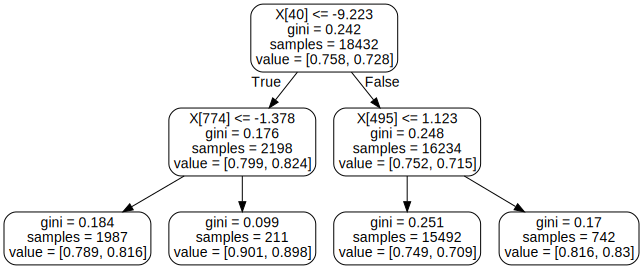

In [245]:
dot_data = export_graphviz(big_cm0.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [237]:
coefs = big_cm0.trans[40-7].coefs
coefs

[-1, -1, -1, 0, -1, 1, -1]

In [238]:
test_cm0 = CoefCM(tree_algs, coefs, -9.223)

In [246]:
nurs1, nurs2, nurs3 = get_results(data_train[0], big_cm0, fried_cm)

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [247]:
(nurs1.mean(), nurs2.mean(), nurs3.mean())

(0.59406171475651881, 0.32732027501026695, 0.42018223519714648)

### Experiment 1

In [173]:
big_cm = combine_cms(out[:1] + out[2:])

In [174]:
big_cm.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=1)
big_cm.retrain_model()

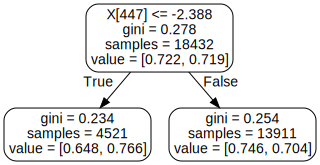

In [175]:
dot_data = export_graphviz(big_cm.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [179]:
coefs0 = big_cm.trans[447-7].coefs
coefs0

[-1, 0, 1, 0, -1, 1, 1]

In [180]:
test_cm1 = CoefCM(tree_algs, coefs0, -2.388)

In [181]:
defaults1, defaults2, defaults3 = get_results(data_train[1], test_cm1, fried_cm)

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [182]:
(defaults1.mean(), defaults2.mean(), defaults3.mean())

(0.64388076957089735, 0.77747889855294039, 0.65413755040832311)

### Experiment 2

In [183]:
big_cm2 = combine_cms(out[:2] + out[3:])

In [78]:
big_cm2.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=1)
big_cm2.retrain_model()

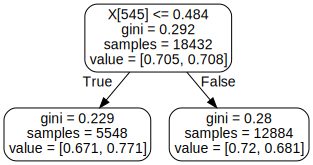

In [79]:
dot_data = export_graphviz(big_cm2.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [184]:
coefs = big_cm2.trans[545-7].coefs
coefs

[-1, 1, -1, 0, 1, 1, 0]

In [185]:
test_cm2 = CoefCM(tree_algs, coefs, 0.484)

In [186]:
loans1, loans2, loans3 = get_results(data_train[2], test_cm2, fried_cm)

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [187]:
(loans1.mean(), loans2.mean(), loans3.mean())

(0.71281690961268562, 0.90724068649198963, 0.77666952792189092)

### Experiment 3

In [188]:
big_cm3 = combine_cms(out[:3] + out[4:])

In [189]:
big_cm3.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=1)
big_cm3.retrain_model()

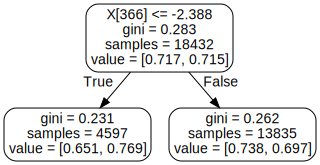

In [190]:
dot_data = export_graphviz(big_cm3.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [192]:
coefs = big_cm3.trans[366-7].coefs
coefs

[-1, 0, 0, 0, -1, 1, 1]

In [194]:
test_cm3 = CoefCM(tree_algs, coefs, -2.388)

In [195]:
adults1, adults2, adults3 = get_results(data_train[3], test_cm3, fried_cm)

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [196]:
(adults1.mean(), adults2.mean(), adults3.mean())

(0.73641029479602826, 0.75530363748071583, 0.67664697966414922)

### Experiment 4

In [199]:
big_cm4 = combine_cms(out[:4] + out[5:])

In [200]:
big_cm4.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=1)
big_cm4.retrain_model()

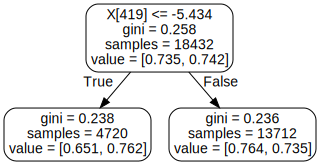

In [202]:
dot_data = export_graphviz(big_cm4.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [203]:
coefs = big_cm4.trans[419-7].coefs
coefs

[-1, 0, 1, -1, -1, 1, 0]

In [204]:
test_cm4 = CoefCM(tree_algs, coefs, -5.434)

In [205]:
lendings1, lendings2, lendings3 = get_results(data_train[3], test_cm4, fried_cm)

Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start1
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start2
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3
Start3


In [206]:
(lendings1.mean(), lendings2.mean(), lendings3.mean())

(0.75084534963292826, 0.75530363748071583, 0.67419395834546814)

In [249]:
lendings1

array([ 0.79485531,  0.75940237,  0.78988561,  0.70393901,  0.75174014,
        0.76889849,  0.66328012,  0.7494877 ,  0.7761194 ])

In [280]:
alg1_error = 1-np.array([nurs1, defaults1, loans1, adults1, lendings1])

In [281]:
alg2_error = 1-np.array([nurs2, defaults2, loans2, adults2, lendings2])

In [282]:
alg3_error = 1-np.array([nurs3, defaults3, loans3, adults3, lendings3])

In [283]:
#best = np.min([alg1_error, alg2_error, alg3_error], axis=0)
#avg_regret1 = (alg1_error-best).reshape((3,-1)).mean(axis=0)
#avg_regret2 = (alg2_error-best).reshape((3,-1)).mean(axis=0)
#avg_regret3 = (alg3_error-best).reshape((3,-1)).mean(axis=0)

In [284]:
alg1_error = alg1_error.reshape((3, -1)).mean(axis=0).reshape((3, -1))
alg2_error = alg2_error.reshape((3, -1)).mean(axis=0).reshape((3, -1))
alg3_error = alg3_error.reshape((3, -1)).mean(axis=0).reshape((3, -1))

In [285]:
alg1_error = alg1_error.mean(axis=1)
alg2_error = alg2_error.mean(axis=1)
alg3_error = alg3_error.mean(axis=1)

In [293]:
juxtaposed_alg_perfs = np.array([alg1_error, alg3_error, alg2_error]).T.flatten()

In [294]:
x_pos = np.array([4*x + y for x in [0,1,2] for y in [0,1,2]])

In [295]:
colors = ['red', 'blue', 'green']*3

In [296]:
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=c) for c in ['red', 'blue', 'green']]

<Container object of 9 artists>

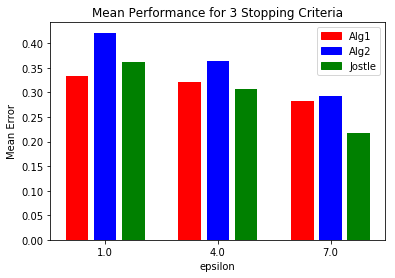

In [297]:
fig, axis = plt.subplots()
axis.set_xticks([1,5,9])
axis.set_xticklabels(['1.0', '4.0', '7.0'])
axis.set_xlabel('epsilon')
axis.set_ylabel('Mean Error')
axis.legend(handles=patches, labels=['Alg1', 'Alg2', 'Jostle'])
axis.set_title('Mean Performance for 3 Stopping Criteria')
axis.bar(x_pos, juxtaposed_alg_perfs, color=colors)

In [ ]:
fig, axis = plt.subplots()
for a in 